## **Word To Vector**

분산 표현: 저차원에 단어의 의미를 여러 차원에다가 분산하여 표현한다.

이런 표현 방법을 사용하면 단어 벡터 간 유의미한 유사도를 계산할 수 있는데 이를 위한 대표적인 방법이 **Word2Vec**이다.

### Word2Vec의 학습 방식

**CBOW(Continuous Bag of Words)**

주변에 있는 단어들을 입력으로 중간에 있는 단어들을 예측하는 방법

윈도우(Window): 중심 단어를 예측하기 위해 앞, 뒤로 몇 개의 단어를 볼지 결정하는 것 

실제 중심 단어를 예측하기 위해 참고하려는 주변 단어의 개수 = 2n

윈도우 슬라이딩(sliding): 윈도우를 옆으로 움직여서 주변 단어와 중심 단어의 선택을 변경해가며 학습을 위한 데이터 셋을 만든다. 

여기서 입력 벡터는 4개이기 때문에 4개의 결과 벡터에 대해 평균을 구한다. 

투사층에서 벡터의 평균을 구하는 것은 Skip-Gram과다른 점!!

평균 벡터는 두 번째 가중치와 곱해진다. 곱셉의 결과로 원-핫 벡터들과 차원이 V로 동일한 벡터가 나온다. 

CBOW는 소프트맥스 함수를 지나면서 벡터의 각 원소들의 값은 0과 1 사이의 실수로 나타난다.

가장 확률이 큰 단어를 중심 단어로 선정한다. 

CBOW는 손실함수로 크로스 엔트로피 함수를 사용한다.  (역전파를 통해 갱신)

**[참고]**

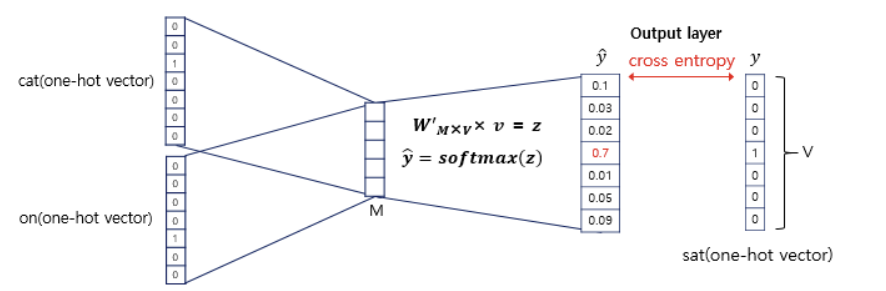

Skip-Gram

중간에 있는 단어들을 입력으로 주변 단어를 예측하는 방법

중심 단어에 대해서 주변 단어를 예측하므로 투사층에서 벡터들의 평균을 구하는 과정이 없다. (입력은 1개, 출력은 여러개라서 그런듯)

**[참고]**

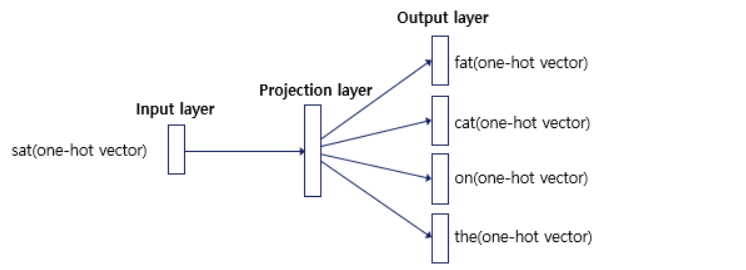

### 실습

In [1]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x19ff6901fc0>)

In [4]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

In [5]:
#content 태그 안에 있는 내용만 가져오기 
parse_text = '\n'.join(target_text.xpath('//content/text()'))

In [7]:
#괄호에 있는 내용 제거
content_text = re.sub(r'\([^)]*\)', '', parse_text)


In [8]:
sent_text = sent_tokenize(content_text)

In [9]:
normalized_text = []
for string in sent_text:
     #영어, 숫자 제외 제거, 대문자는 소문자로 변환
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower()) 
     normalized_text.append(tokens)

In [10]:
result = [word_tokenize(sentence) for sentence in normalized_text]

In [11]:
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


In [13]:
!pip install gensim

     --------------------------------------- 24.0/24.0 MB 38.6 MB/s eta 0:00:00


In [14]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

#CBOW를 사용하여 중심단어 예측하기 
model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=0)

In [15]:
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.8440277576446533), ('guy', 0.7881478667259216), ('boy', 0.7753100991249084), ('lady', 0.7701045274734497), ('girl', 0.7447904944419861), ('gentleman', 0.7237016558647156), ('soldier', 0.7203381061553955), ('kid', 0.67896968126297), ('photographer', 0.6711264252662659), ('poet', 0.6535753607749939)]


In [17]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [18]:
model_result = loaded_model.most_similar("man")
print(model_result)

[('woman', 0.8440277576446533), ('guy', 0.7881478667259216), ('boy', 0.7753100991249084), ('lady', 0.7701045274734497), ('girl', 0.7447904944419861), ('gentleman', 0.7237016558647156), ('soldier', 0.7203381061553955), ('kid', 0.67896968126297), ('photographer', 0.6711264252662659), ('poet', 0.6535753607749939)]


## **FastText**

Word2Vec는 단어를 쪼개질 수 없는 단위로 생각하지만, FastText는 하나의 단어 안에도 여러 단어들이 존재하는 것으로 간주한다. 

즉, 서브워드(subword)를 고려하여 학습한다.

#### n-gram

FastText는 각 단어는 글자 단위 n-gram의 구성으로 취급한다.

if n = 3 :

"apple" = <'ap', 'app', 'ppl', 'ple', 'le'> # 앞, 뒤의 문자는 n-1값도 해줘야 하나보다 ..

한국어를 음절 단위로 나눌 때도 n = 3일 때 '자연어처리'를 n-gram으로 만든다면,

<자연, 자연어, 연어처, 어처리, 처리>로 출력된다. 

**모르는 단어 OOV에 대한 대응**

데이터셋이 충분하다면, 내부 단어를 통해 모르는 단어에 대해서도 다른 단어와의 유사도를 계산할 수 있다.

예를 들면, birthplace에서 'birth', 'place'가 사전에 각각 저장되어 있다면 'birthplace' 또한 벡터를 얻을 수 있다.

#### Word2Vec Vs. FastText

In [19]:
#Word2Vec으로 생성한 사전에 단어가 없어서 오류를 반환한다. 
model.wv.most_similar("electrofishing")

KeyError: "Key 'electrofishing' not present in vocabulary"

In [21]:
from gensim.models import FastText

model = FastText(result, vector_size=100, window=5, min_count=5, workers=4, sg=1)

In [22]:
#FastText는 단어가 사전에 없어도 비슷한 단어들을 출력해준다.

model.wv.most_similar("electrofishing")

[('electrolux', 0.8640275001525879),
 ('electrolyte', 0.8605923056602478),
 ('electro', 0.8415747880935669),
 ('electroshock', 0.8394865989685059),
 ('electroencephalogram', 0.835127055644989),
 ('airbus', 0.8231889009475708),
 ('airbag', 0.8201907277107239),
 ('electrogram', 0.8174833655357361),
 ('electric', 0.8156371712684631),
 ('electronic', 0.8122113943099976)]

## **Average Word Average : 문서 임베딩**

In [23]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
# 등장 빈도 순위가 20,000등이 넘는 단어들은 데이터를 로드할 때 전부 제거
vocab_size = 20000

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)
print('훈련용 리뷰 개수 :',len(X_train))
print('테스트용 리뷰 개수 :',len(X_test))

17464789/17464789 [==============================] - 2s 0us/step
훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000


In [26]:
print('훈련 데이터의 첫번째 샘플 :',X_train[0])
print('훈련 데이터의 첫번째 샘플의 레이블 :', y_train[0])

훈련 데이터의 첫번째 샘플 : [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
훈련 데이터의 첫번째 샘플의 레이블 : 1


In [27]:
print('훈련용 리뷰의 평규 길이: {}'.format(np.mean(list(map(len, X_train)), dtype=int)))
print('테스트용 리뷰의 평균 길이: {}'.format(np.mean(list(map(len, X_test)), dtype=int)))

훈련용 리뷰의 평규 길이: 238
테스트용 리뷰의 평균 길이: 230


In [28]:
max_len = 400 #그냥 평균보다 큰 수치인 400으로 패딩한다. 

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
print('X_train의 크기(shape) :', X_train.shape)
print('X_test의 크기(shape) :', X_test.shape)

X_train의 크기(shape) : (25000, 400)
X_test의 크기(shape) : (25000, 400)


In [29]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
embedding_dim = 64

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))

# 모든 단어 벡터의 평균을 구한다.
model.add(GlobalAveragePooling1D()) #해당 문장의 모든 단어 벡터들의 평균 벡터를 구한다.
model.add(Dense(1, activation='sigmoid'))

In [31]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
#embedding_average_model.h5에 최적의 모델 가중치 저장
#val_acc = 모델의 성능을 모니터링할 지표로, 검증 데이터셋에서의 정확도를 의미
mc = ModelCheckpoint('embedding_average_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [32]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [33]:
model.fit(X_train, y_train, batch_size=32, epochs=10, callbacks=[es, mc], validation_split=0.2)

Epoch 1/10
623/625 [============================>.] - ETA: 0s - loss: 0.6300 - acc: 0.7152
Epoch 1: val_acc improved from -inf to 0.81360, saving model to embedding_average_model.h5
625/625 [==============================] - 8s 12ms/step - loss: 0.6296 - acc: 0.7156 - val_loss: 0.5224 - val_acc: 0.8136
Epoch 2/10
  9/625 [..............................] - ETA: 9s - loss: 0.5024 - acc: 0.8438

c:\Users\ahyeo\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - ETA: 0s - loss: 0.4311 - acc: 0.8582
Epoch 2: val_acc improved from 0.81360 to 0.86360, saving model to embedding_average_model.h5
625/625 [==============================] - 9s 14ms/step - loss: 0.4311 - acc: 0.8582 - val_loss: 0.3795 - val_acc: 0.8636
Epoch 3/10
622/625 [============================>.] - ETA: 0s - loss: 0.3194 - acc: 0.8910
Epoch 3: val_acc improved from 0.86360 to 0.87980, saving model to embedding_average_model.h5
625/625 [==============================] - 9s 14ms/step - loss: 0.3192 - acc: 0.8910 - val_loss: 0.3233 - val_acc: 0.8798
Epoch 4/10
622/625 [============================>.] - ETA: 0s - loss: 0.2621 - acc: 0.9100
Epoch 4: val_acc improved from 0.87980 to 0.88720, saving model to embedding_average_model.h5
625/625 [==============================] - 8s 13ms/step - loss: 0.2621 - acc: 0.9100 - val_loss: 0.2977 - val_acc: 0.8872
Epoch 5/10
625/625 [==============================] - ETA: 0s - loss: 0.2243 - acc: 0.9244

In [34]:
loaded_model = load_model('embedding_average_model.h5') #모델의 가중치 로드
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

782/782 [==============================] - 2s 2ms/step - loss: 0.2911 - acc: 0.8878

 테스트 정확도: 0.8878


## **Doc2Vec**

In [36]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XS0UlE8gNNTRjnL6e64sMacOhtVERIqL' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1XS0UlE8gNNTRjnL6e64sMacOhtVERIqL" -O dart.csv && rm -rf /tmp/cookies.txt

'wget'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [37]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     --------------------------------------- 19.4/19.4 MB 38.4 MB/s eta 0:00:00
     ------------------------------------- 345.1/345.1 kB 22.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 501.3/501.3 kB 7.9 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1240 sha256=fffd8b6a87fde0662985772e144c269e3a499adf8a615350ef21ab5869ed11f5
  Stored in directory: c:\users\ahyeo\appdata\local\pip\cache\wheels\9b\3a\4e\30925e715fc802d2e2a040014a52b17c749c2c5fbc6856e781
Successfully built mecab-python


������ ������ ã�� �� �����ϴ�.


In [38]:
import pandas as pd
from konlpy.tag import Mecab
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm

In [ ]:
df = pd.read_csv('/content/dart.csv',  sep=',')
df = df.dropna()
df

In [ ]:
mecab = Mecab() #형태소 분석기

tagged_corpus_list = [] #문서의 제목, 본문에 해당하는 단어 토큰화 결과 저장

for index, row in tqdm(df.iterrows(), total=len(df)):
  text = row['business'] #본문
  tag = row['name'] #기업 이름 
  tagged_corpus_list.append(TaggedDocument(tags=[tag], words=mecab.morphs(text)))

print('문서의 수 :', len(tagged_corpus_list))

In [ ]:
tagged_corpus_list[0] #첫번째 본문의 토큰화된 결과 출력 

In [ ]:
from gensim.models import doc2vec

In [ ]:
#모델 생성
model = doc2vec.Doc2Vec(vector_size=300, alpha=0.025, min_alpha=0.025, workers=8, window=8)

# Vocabulary 빌드
model.build_vocab(tagged_corpus_list)
print(f"Tag Size: {len(model.docvecs.doctags.keys())}", end=' / ') #모델이 학습한 문서의 개수
 
# Doc2Vec 학습
model.train(tagged_corpus_list, total_examples=model.corpus_count, epochs=50)

# 모델 저장
model.save('dart.doc2vec')

In [ ]:
similar_doc = model.docvecs.most_similar('동화약품')
print(similar_doc)

In [ ]:
similar_doc = model.docvecs.most_similar('하이트진로')
print(similar_doc)

In [ ]:
similar_doc = model.docvecs.most_similar('LG이노텍')
print(similar_doc)

In [ ]:
similar_doc = model.docvecs.most_similar('메리츠화재')
print(similar_doc)

In [ ]:
similar_doc = model.docvecs.most_similar('카카오')
print(similar_doc)